In [60]:
import pandas as pd
import numpy as np
import copy
from collections import deque
from pandas.core.frame import DataFrame
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [61]:
mu, sigma = 10, 3
s1 = st.norm(mu, sigma).rvs(1000000)
s2 = st.norm(mu-6, sigma+6).rvs(100000)

df_1 = pd.DataFrame(s1,columns=["feat"]  )
df_1['Y'] = 0
df_2 = pd.DataFrame(s2,columns=["feat"]  )
df_2['Y'] = 1

df = pd.concat([df_1,df_2],axis=0).reset_index(drop=True)
df.head(5)

,feat,Y
0,11.833398,0
1,11.646245,0
2,11.710963,0
3,11.360147,0
4,10.517534,0


In [62]:
feature_cols = [col for col in df.columns if col != 'Y']
target_cols = [col for col in df.columns if col not in feature_cols]

<Figure size 432x288 with 0 Axes>

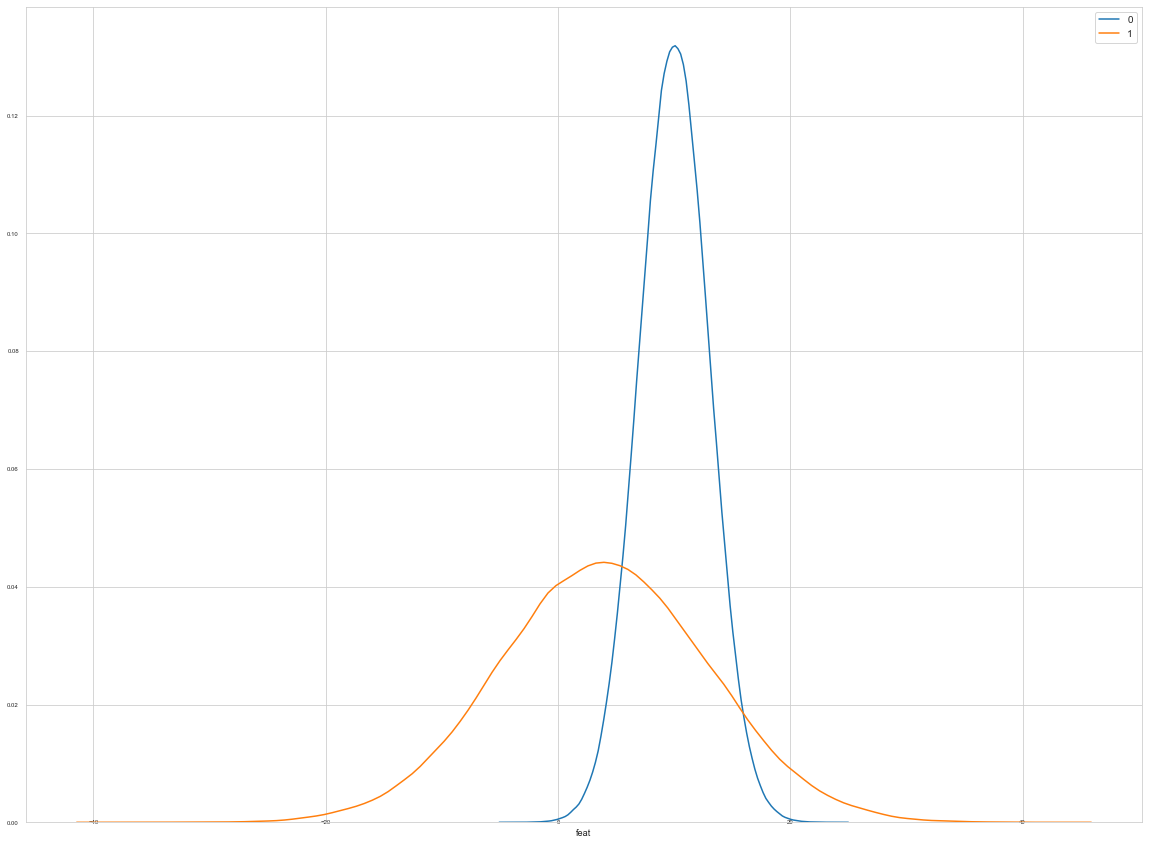

In [63]:
def plot_feature_distribution(df1, df2, label1, label2, features,plot_rows,plot_cols):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(20,15))

    for feature in features:
        i += 1
        plt.subplot(plot_rows,plot_cols,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

t0 = df.loc[df['Y'] == 0]
t1 = df.loc[df['Y'] == 1]
#features = df.columns.values[0]
plot_feature_distribution(t0, t1, '0', '1', feature_cols,1,1)

### PDF Method

* Input一個Feat & Label, 得到各點P(Y=1) - P(Y=0)的機率
* 若該值是正,代表該值域下1的樣本點比0多

In [64]:
def PDF_func(dataframe,feature,start,end,step,FileName):
    #initial
    N = len(dataframe[feature])
    seq = dataframe[feature].sort_values().reset_index(drop=True)
    pdf_range = range(start,end,step)
    
    tmp_pdframe = pd.DataFrame(
            [sum((pdf_range[i-1]<seq ) & (seq<pdf_range[i]))/N for i in range(1,len(pdf_range))]
            ,columns=['pdf'])
    #N個數有N-1個區間
    #區間長度:Index~Index+step
    tmp_pdframe.index = pdf_range[:-1]
    globals()['pdf_frame_'+str(FileName)] = tmp_pdframe
    print("Done!File Name: pdf_frame_"+ str(FileName))

In [65]:
PDF_func(df[df['Y']==1],'feat',int(min(df['feat'])),int(max(df['feat'])),1,'feat_1')
PDF_func(df[df['Y']==0],'feat',int(min(df['feat'])),int(max(df['feat'])),1,'feat_0')

Done!File Name: pdf_frame_feat_1
Done!File Name: pdf_frame_feat_0


In [66]:
pdf_frame_feat_1.head(10)

,pdf
-38,0.00000
-37,0.00000
-36,0.00000
-35,0.00000
-34,0.00001
-33,0.00004
-32,0.00003
-31,0.00005
-30,0.00004
-29,0.00004


In [67]:
pdf_frame_feat_0.head(10)

,pdf
-38,0.0
-37,0.0
-36,0.0
-35,0.0
-34,0.0
-33,0.0
-32,0.0
-31,0.0
-30,0.0
-29,0.0


In [68]:
pdf_diff = pdf_frame_feat_1-pdf_frame_feat_0

In [69]:
pdf_diff.head(20)

,pdf
-38,0.00000
-37,0.00000
-36,0.00000
-35,0.00000
-34,0.00001
-33,0.00004
-32,0.00003
-31,0.00005
-30,0.00004
-29,0.00004


In [70]:
df['pdf_diff_feat']=pdf_diff.loc[round(df['feat'])].reset_index(drop=True)
#偶爾會有NA值

C:\Users\w9012219\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


### Try On XGB

* XGB本質迭代是切分值域,切分後值域會漸漸縮小 -> 隱含yi只能被值域鄰近的樣本來預測
* 同棵樹內:值域變小 / 不同棵樹:繼續grouping
* X分配只有偏斜一邊->leaf / X分配偏斜一邊以上->level

Type 1: without pdf_diff_feat..

In [71]:
import xgboost as xgb
param = {'max_depth': 8,
         'learning_rate ': 0.01,
         'silent': 1,
         'objective': 'binary:logistic',
         "eval_metric":"auc"
         #"scale_pos_weight":10,
         #"subsample":0.9,
         #"min_child_weight":5,
          }

x_col=['feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484693           0.000129           0.484909          0.000069
1             0.371463           0.000044           0.371858          0.000143
2             0.303099           0.000053           0.303674          0.000077
3             0.259472           0.000077           0.260232          0.000076
4             0.231381           0.000253           0.232308          0.000082
5             0.213169           0.000069           0.214270          0.000127
6             0.201424           0.000205           0.202698          0.000011
7             0.193918           0.000071           0.195394          0.000160
8             0.189122           0.000168           0.190769          0.000086
9             0.186148           0.000141           0.187975          0.000149
10            0.184413           0.000165           0.186401          0.000141
11            0.183335           0.000156           

In [72]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 189.85196255777976}

Type 2: add pdf_diff_feat!

In [73]:
x_col=['feat','pdf_diff_feat']
train_X = df[x_col]

y_col=['Y']
train_Y = df[y_col]

dtrain = xgb.DMatrix(train_X,label=train_Y)

cv_res= xgb.cv(param,
               dtrain,
               num_boost_round=1000,#830
               early_stopping_rounds=10,
               nfold=2, metrics='logloss',show_stdv=True)

print(cv_res)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.484893           0.000148           0.485081          0.000187
1             0.371841           0.000020           0.372190          0.000088
2             0.303233           0.000072           0.303764          0.000035
3             0.259651           0.000063           0.260329          0.000055
4             0.231555           0.000073           0.232409          0.000067
5             0.213272           0.000083           0.214261          0.000086
6             0.201552           0.000106           0.202721          0.000080
7             0.193974           0.000154           0.195309          0.000068
8             0.189249           0.000126           0.190748          0.000122
9             0.186366           0.000091           0.188030          0.000152
10            0.184530           0.000117           0.186359          0.000137
11            0.183427           0.000100           

In [74]:
bst = xgb.train(param,dtrain,num_boost_round=cv_res.shape[0])
bst.get_score(importance_type='gain')

{'feat': 140.26763163774544, 'pdf_diff_feat': 1645.695178985957}

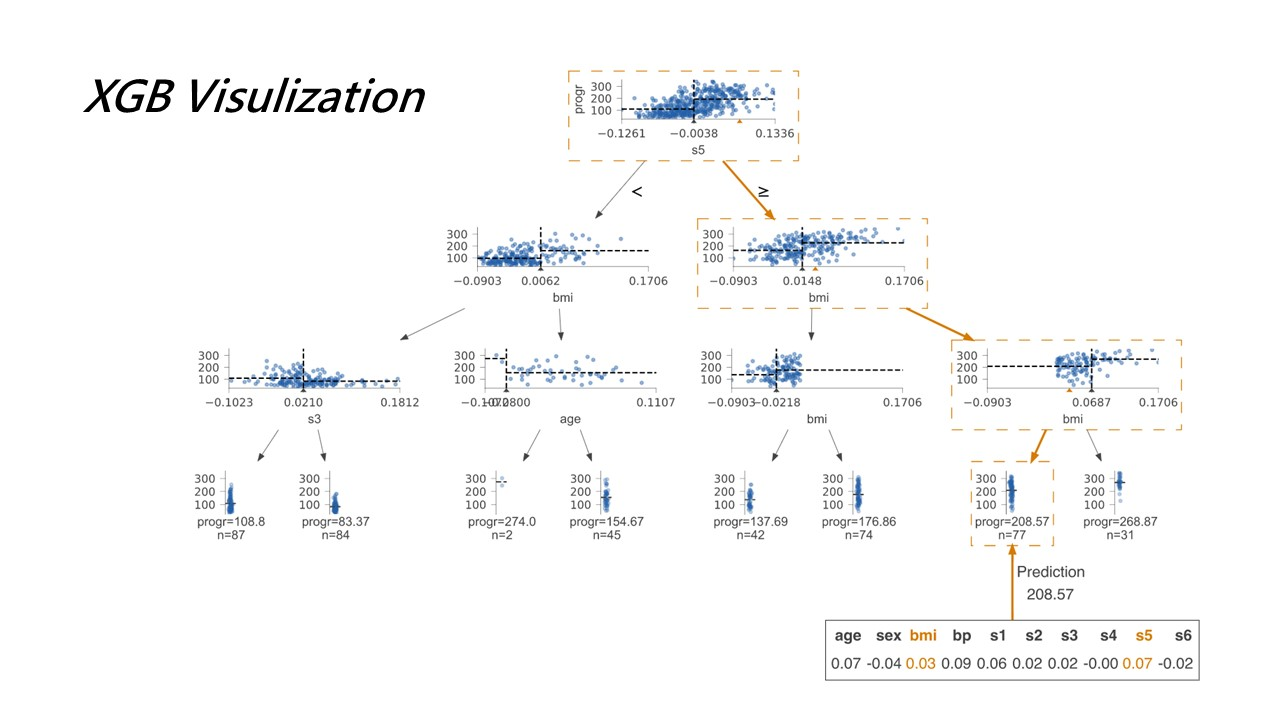

In [75]:
from IPython.display import Image
Image("XGB visulization.jpg")